In [1]:
from fastai.vision.all import *
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import umap

In [2]:
np.random.seed(8675309)
dest_path = "/home/jupyter/data/"
path = Path("{}egyptian_fruit_bat_annotated_tiny_cqt".format(dest_path))
files = [str(x) for x in get_image_files(path)]

print("Found {} squeaks!".format(len(files)))
files[0]

Found 8224 squeaks!


'/home/jupyter/data/egyptian_fruit_bat_annotated_tiny_cqt/files210/121220010548932125.png'

In [3]:
annotations_full = pd.read_csv("{}/egyptian_fruit_bat_annotated_tiny/better_annotations.csv".format(dest_path))
annotations_full.head()

context_dict = {0:"unknown", 1:"separation", 2:"biting", 
                3:"feeding", 4:"fighting", 5:"grooming", 
                6:"isolation", 7:"kissing", 8:"landing", 
                9:"mating protest", 10:"threat-like", 
                11:"general", 12:"sleeping"}

annotations = annotations_full.loc[:,["File name", "File folder", "Context"]]
annotations["Context desc."] = [context_dict[x] for x in annotations["Context"]]
annotations["File name"] = [x.replace(".WAV", ".png") for x in annotations["File name"] ]
annotations["File path"] = ["{}/{}/{}".format(str(path),
                                              str(annotations['File folder'][i]), 
                                              str(annotations['File name'][i])) for i in annotations.index]
annotations = annotations[annotations["File path"].isin(files)]
annotations = annotations.drop_duplicates(subset = ['File path'])

annotations = annotations.loc[annotations['Context desc.'] != 'landing']
annotations = annotations.loc[annotations['Context desc.'] != 'unknown']
annotations = annotations.loc[annotations['Context desc.'] != 'general']

annotations.head()

,File name,File folder,Context,Context desc.,File path
6,120601011044407132.png,files101,1,separation,/home/jupyter/data/egyptian_fruit_bat_annotated_tiny_cqt/files101/120601011044407132.png
7,120601011047196133.png,files101,1,separation,/home/jupyter/data/egyptian_fruit_bat_annotated_tiny_cqt/files101/120601011047196133.png
23,120601041134496318.png,files101,12,sleeping,/home/jupyter/data/egyptian_fruit_bat_annotated_tiny_cqt/files101/120601041134496318.png
54,120601163203025371.png,files101,12,sleeping,/home/jupyter/data/egyptian_fruit_bat_annotated_tiny_cqt/files101/120601163203025371.png
118,120603011026138518.png,files101,12,sleeping,/home/jupyter/data/egyptian_fruit_bat_annotated_tiny_cqt/files101/120603011026138518.png


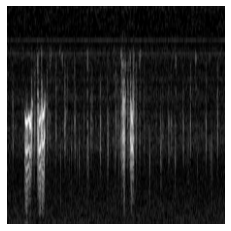

In [4]:
plt.imshow(Image.open(files[10]))
plt.axis("off")
plt.show()

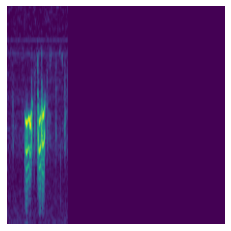

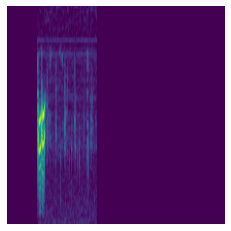

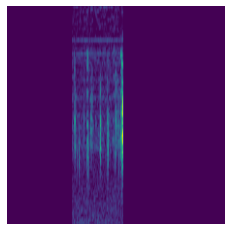

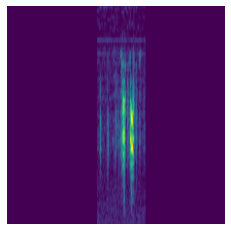

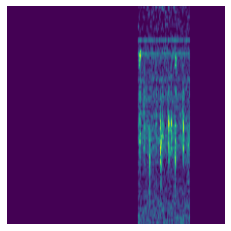

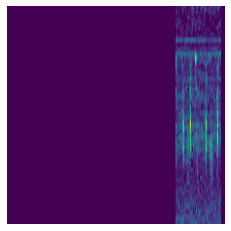

In [5]:
def get_x(p):
    #returns a gs numpy array
    return  np.array(Image.open(p))[:, :, 0]

def pos_enc2d_np(gs_im, out_c = 5, eta = 0.05):
    def constrain(x, a, b):
        if x > b: return b
        if x < a: return a
        else: return x

    def make_mask(shape, start, end):
        #returns a vertical mask:
        block_0 = np.zeros((shape[1], start))
        block_1 = np.ones((shape[1], end - start))
        block_2 = np.zeros((shape[1], constrain(shape[0] - end, 0, shape[0])))
        mask = np.block([block_0, block_1, block_2])
        
        if mask.shape != shape:
            return mask[:shape[1], :shape[1]]
        else: return mask

    window_widths = np.random.uniform(float(1/(out_c-2)) - eta, 
                                      float(1/(out_c-2)) + eta, out_c)
    window_widths = np.round(window_widths*gs_im.shape[0]).astype(np.uint8)   
    
    window_starts = np.random.uniform(float(1/out_c) - eta, 
                                      float(1/out_c) + eta, out_c)
    
    window_starts = np.array([sum(window_starts[0:i]) for i in range(out_c)])
    window_starts = np.round(window_starts*gs_im.shape[0]).astype(np.uint8)   
    new_ims = []
    
    for i in range(out_c):
        if i < out_c:
            temp_mask = make_mask(gs_im.shape, 
                                  start = window_starts[i], 
                                  end = window_starts[i] + window_widths[i])
        if i == out_c:
            #making sure the last mask gets the last of the image:
            temp_mask = make_mask(gs_im.shape, 
                                  start = int(gs_im.shape[0]*out_c), 
                                  end = gs_im.shape[0])

        new_ims.append(np.multiply(temp_mask, gs_im))
    return np.dstack(new_ims)       

    
c = 6
x = get_x(files[10])
pos_enc_x = pos_enc2d_np(x, out_c = c)
for i in range(c):
    plt.imshow(pos_enc_x[:, :, i])
    plt.axis("off")
    plt.show()

In [6]:
a = np.array([np.random.rand(100, 100).reshape(1, 100, 100) for _ in range(1)])
a = torch.from_numpy(a)
a.shape

torch.Size([1, 1, 100, 100])

In [7]:
def pos_enc2d_layer(tensor, out_c = 6, eta = 0.05):
    #adapting the pos_enc2d to act as a layer in the model:
    bs, channels, h, w = tensor.shape
    assert channels == 1, "Input should have one channel!"
    np_tensor = np.array(tensor.cpu()) #a little hacky! probably could be better!
    stack = [pos_enc2d_np(np_tensor[i,:, :, :].reshape(h, w), out_c, eta) for i in range(bs)]
    stack  = np.array(stack).reshape(bs, out_c, h, w)
    return torch.from_numpy(stack).type(torch.cuda.FloatTensor)

pos_enc2d_layer(a).shape

torch.Size([1, 6, 100, 100])

In [8]:
def get_y(p, annotations = annotations):
    return annotations.loc[annotations['File path'] == p]['Context desc.'].values[0]

def get_items(p, annotations = annotations):
    temp_files = [str(x) for x in get_image_files(path)]
    return annotations.loc[annotations['File path'].isin(temp_files)]['File path'].values

In [9]:
dls = DataBlock(blocks = (ImageBlock, CategoryBlock), 
               get_items = get_items, 
               get_x = get_x, 
               get_y = get_y, 
               splitter = RandomSplitter(seed = 42)).dataloaders(path, 
                                                                 bs = 128)

In [10]:
dls.c

10

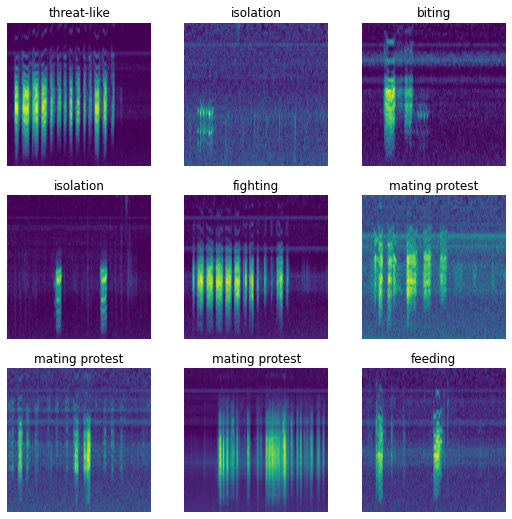

In [11]:
dls.show_batch()

In [13]:
class res_model(Module):    
    def __init__(self, with_pos_enc = True):
        super().__init__()
        
        self.with_pos_enc = with_pos_enc
        self.in_c = (1, 5)[with_pos_enc]
        self.out_c = 10
        
        self.conv_block1 = nn.Sequential(
                     nn.Conv2d(kernel_size = (5, 5),
                               in_channels = self.in_c, 
                               out_channels = self.in_c, 
                               stride = (3, 3), 
                               padding = (1, 1), 
                               bias = False), 
                     nn.BatchNorm2d(self.in_c, 
                                    momentum = 0.1, 
                                    affine = True, 
                                    track_running_stats = True),
                     nn.ReLU(inplace = True),
                     nn.MaxPool2d(kernel_size = (3, 3), 
                                  stride = (3, 3), 
                                  padding  = 1, 
                                  dilation = 1, 
                                  ceil_mode = False),
                     nn.Conv2d(in_channels = self.in_c, 
                               out_channels = 128,
                               kernel_size = (3, 3), 
                               stride = (1, 1), 
                               padding = (1, 1), 
                               bias = False),
                     nn.BatchNorm2d(128, 
                                    momentum = 0.1, 
                                    affine = True, 
                                    track_running_stats = True),
                     nn.ReLU(inplace = True),
                     nn.Conv2d(in_channels = 128, 
                               out_channels = 512, 
                               kernel_size = (3, 3), 
                               stride = (1, 1), 
                               padding = (1, 1), 
                               bias = False),
                     nn.ReLU(inplace = True),
                     nn.Conv2d(in_channels = 512, 
                               out_channels = 128, 
                               kernel_size = (3, 3), 
                               stride = (1, 1), 
                               padding = (1, 1), 
                               bias = False),
                     nn.BatchNorm2d(128, 
                                    momentum = 0.1, 
                                    affine = True, 
                                    track_running_stats = True),
                     nn.ReLU(inplace = True),
                     nn.Conv2d(in_channels = 128, 
                               out_channels = 64, 
                               kernel_size = (3, 3), 
                               stride = (1, 1), 
                               padding = (1, 1), 
                               bias = False),
                     nn.BatchNorm2d(64, 
                                    momentum = 0.1, 
                                    affine = True, 
                                    track_running_stats = True),
                     nn.Conv2d(in_channels = 64, 
                               out_channels = 32, 
                               kernel_size = (3, 3), 
                               stride = (1, 1), 
                               padding = (1, 1), 
                               bias = False),
                     nn.BatchNorm2d(32, 
                                    momentum = 0.1, 
                                    affine = True, 
                                    track_running_stats = True),
                     nn.AdaptiveAvgPool2d(output_size = (10, 10)),
                     nn.AdaptiveMaxPool2d(output_size = 1)
                    )
        
        self.linear_block1 = nn.Sequential(
                     Flatten(),
                     nn.Linear(in_features = 32, 
                               out_features = 64),
                     nn.ReLU(inplace = True),
                     nn.Linear(in_features = 64, 
                               out_features = 32),
                     nn.ReLU(inplace = True),
                     nn.Linear(in_features = 32, 
                               out_features = 32),
                     nn.ReLU(inplace = True),
                     nn.Linear(in_features = 32, 
                               out_features = 32),
                     nn.ReLU(inplace = True)
                     )

        self.dropout = nn.Dropout(p = 0.1)
        
        self.classifier = nn.Sequential(
                    nn.Linear(32, self.out_c),
                    nn.Sigmoid()
                    )

        
    def forward(self, x):
        if self.with_pos_enc:
            x = pos_enc2d_layer(x, out_c = self.in_c)
            
        x = self.conv_block1(x)
        x = self.dropout(x)
        x = self.linear_block1(x)
        self.linear_layer_output = x
        x = self.linear_block1(x)
        x = self.classifier(x)
        return x



In [14]:
pe_learner = Learner(dls, res_model(), metrics = accuracy)
no_pe_learner = Learner(dls, res_model(with_pos_enc = False), metrics = accuracy)

In [15]:
print("Training learner with pos enc...\n")
pe_learner.fit_one_cycle(8, 1e-3)
print("Training learner without pos enc...\n")
no_pe_learner.fit_one_cycle(8, 1e-2)

Training learner with pos enc...



epoch,train_loss,valid_loss,accuracy,time
0,2.301116,2.300415,0.119048,00:33
1,2.285987,2.281188,0.129464,00:31
2,2.242466,2.211139,0.196429,00:31
3,2.208650,2.172427,0.191964,00:31
4,2.168163,2.133404,0.190476,00:31
5,2.139353,2.110841,0.221726,00:31
6,2.120177,2.106770,0.215030,00:31
7,2.108313,2.100045,0.221726,00:31


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in ubyte_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in ubyte_scalars
  


Training learner without pos enc...



epoch,train_loss,valid_loss,accuracy,time
0,2.288330,2.273860,0.129464,00:07
1,2.259256,2.287403,0.106399,00:07
2,2.271544,2.309837,0.106399,00:07
3,2.273088,2.266361,0.106399,00:06
4,2.257945,2.264207,0.106399,00:07
5,2.234201,2.206225,0.106399,00:06
6,2.213221,2.190987,0.106399,00:06
7,2.198354,2.188260,0.106399,00:06


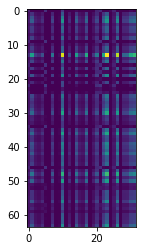

In [16]:
#here's how we can grab the linear layer's output:

layer_outputs = np.array(pe_learner.model.linear_layer_output.cpu().detach().numpy())
plt.imshow(layer_outputs)

In [17]:
from tqdm import trange

def plot_inner_layer_UMAP(learn, data):
    #now let's get run through some data and look inside the model:
    layer_outputs = []
    layer_labels = []
    dls_iter = next(iter(data)) 
    model = learn.model.eval()

    for _ in trange(60):
        ims, labels = next(iter(dls_iter))
        model(ims);
        batch_output = model.linear_layer_output.cpu().detach().numpy()

        [layer_labels.append(x) for x in labels.cpu().detach().numpy()];
        [layer_outputs.append(x) for x in batch_output];
        
    layer_labels_desc = [context_dict[i] for i in layer_labels]
    layer_outputs = np.array(layer_outputs)
    
    umap_transform = umap.UMAP(low_memory=False,
                           n_neighbors=15,
                           min_dist=0.01,
                           n_components=2,
                           random_state=42,
                           target_metric='categorical').fit_transform(layer_outputs)
    plt.figure(figsize = (7, 7))

    for i, l in enumerate(list(context_dict.values())):
        label_mask = [x == l for x in layer_labels_desc]
        plt.scatter(umap_transform[label_mask][:, 0], 
                    umap_transform[label_mask][:, 1], 
                    label = l,
                    s = 3, 
                    marker = "s", 
                    alpha = 0.5,
                    color = plt.get_cmap("tab20")(i))

    plt.legend(loc = 'upper left', bbox_to_anchor=(1.05, 1))
    plt.axis("off")
    plt.show()

100%|██████████| 60/60 [01:45<00:00,  1.76s/it]


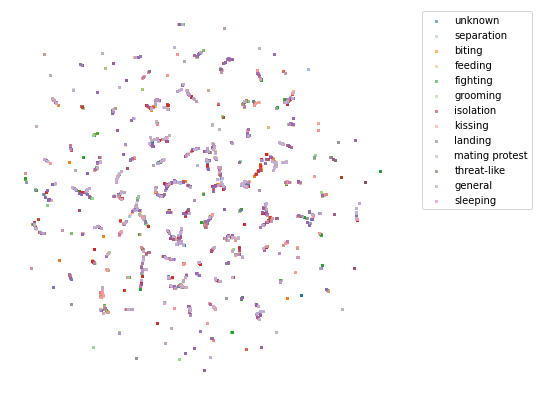

In [18]:
plot_inner_layer_UMAP(no_pe_learner, dls)

  0%|          | 0/60 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in ubyte_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in ubyte_scalars
  
100%|██████████| 60/60 [02:17<00:00,  2.29s/it]


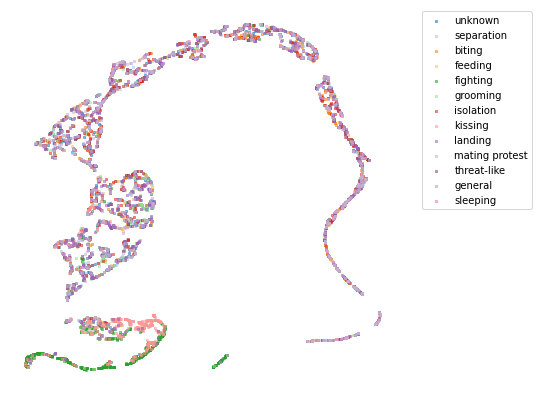

In [19]:
plot_inner_layer_UMAP(pe_learner, dls)